In [6]:
from cc.collect import collect_reference_source, collect_exhaust_source, collect 
from cc import save, load 
from cc.controller import create_pi_controller, LinearController, LinearControllerOptions
from cc.env.wrappers import AddReferenceObservationWrapper, RecordVideoWrapper
import matplotlib.pyplot as plt 
from cc.env import make_env
from cc.train import TrainingOptionsController, train_controller
import optax 

In [7]:
from cc.utils.utils import generate_ts


time_limit = 10.0
control_timestep = 0.01 
ts = generate_ts(time_limit, control_timestep)

env = make_env("two_segments_v1", random=1, time_limit=time_limit, control_timestep=control_timestep)

In [9]:
# create a reference source with two *feasible* (=physically possible) trajectories
source = collect_reference_source(env, seeds=[20,21], constant_after=True, constant_after_T=3.0)

In [10]:
p_gain = 0.01
i_gain = 0.0 

options = create_pi_controller(p_gain, i_gain, delta_t=control_timestep)

In [11]:
controller = LinearController(options)

In [12]:
controller

LinearController(
  rhs=LinearRHS(
    params=LinearRHS_Params(
      A=NotAParameter(_=f32[2,2]),
      B=NotAParameter(_=f32[2,1]),
      C=Parameter(_=f32[1,2]),
      D=NotAParameter(_=f32[1,1])
    ),
    _init_state=NotAParameter(_=f32[2]),
    method='no-integrate'
  ),
  state=NotAParameter(_=f32[2]),
  input_size=1,
  output_size=1
)

In [13]:
training_options = TrainingOptionsController(
    optax.adam(3e-3), 0.0, 500, 1, models=[model]
)

In [14]:
controller, losses = train_controller(controller, source, training_options)

  0%|                                                                                                                                                                                                                                                                  | 0/500 [00:00<?, ?it/s]

            If this message is display continuously then you probably forgot to compile the model or controller. 
            This can be fixed by calling `*model/controller* = equniox.filter_jit(*model/controller*).
            
            If this message is display continuously then you probably forgot to compile the model or controller. 
            This can be fixed by calling `*model/controller* = equniox.filter_jit(*model/controller*).
            
            If this message is display continuously then you probably forgot to compile the model or controller. 
            This can be fixed by calling `*model/controller* = equniox.filter_jit(*model/controller*).
            


Trainings-Loss:    39.7957 | ParamsRegu:     0.0001:   0%|▍                                                                                                                                                                                                    | 1/500 [00:00<06:44,  1.23it/s]

            If this message is display continuously then you probably forgot to compile the model or controller. 
            This can be fixed by calling `*model/controller* = equniox.filter_jit(*model/controller*).
            
            If this message is display continuously then you probably forgot to compile the model or controller. 
            This can be fixed by calling `*model/controller* = equniox.filter_jit(*model/controller*).
            
            If this message is display continuously then you probably forgot to compile the model or controller. 
            This can be fixed by calling `*model/controller* = equniox.filter_jit(*model/controller*).
            


Trainings-Loss:     9.5105 | ParamsRegu:     0.0039: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 72.47it/s]


In [15]:
# final gain values
controller.rhs.params.C()

DeviceArray([[ 0.08696828, -0.01427839]], dtype=float32)

### So how well does our controller now perform in the actual environment? :D 

In [16]:
env_w_source = AddReferenceObservationWrapper(env, source)

In [17]:
iterator = collect(env=env_w_source, controller=controller, ts=ts)
replay_sample = next(iterator)

            If this message is display continuously then you probably forgot to compile the model or controller. 
            This can be fixed by calling `*model/controller* = equniox.filter_jit(*model/controller*).
            


In [18]:
replay_sample.obs

OrderedDict([('obs',
              OrderedDict([('xpos_of_segment_end',
                            array([[[2.5717583e-16],
                                    [2.5717583e-16],
                                    [2.5717583e-16],
                                    ...,
                                    [9.2908554e+00],
                                    [9.2533426e+00],
                                    [9.2159061e+00]]], dtype=float32))])),
             ('ref',
              OrderedDict([('xpos_of_segment_end',
                            array([[[2.5717583e-16],
                                    [2.4853820e-05],
                                    [5.6197499e-05],
                                    ...,
                                    [1.1927854e+01],
                                    [1.1927854e+01],
                                    [1.1927854e+01]]], dtype=float32))]))])

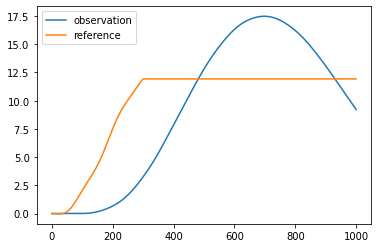

In [19]:

plt.plot(replay_sample.obs["obs"]["xpos_of_segment_end"][0], label="observation")
plt.plot(replay_sample.obs["ref"]["xpos_of_segment_end"][0], label="reference")
plt.legend()

In [20]:
source.change_reference_of_actor(1)
iterator = collect(env=env_w_source, controller=controller, ts=ts)
replay_sample = next(iterator)

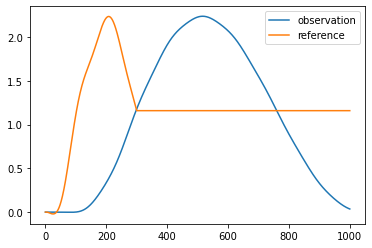

In [21]:

plt.plot(replay_sample.obs["obs"]["xpos_of_segment_end"][0], label="observation")
plt.plot(replay_sample.obs["ref"]["xpos_of_segment_end"][0], label="reference")
plt.legend()

Want a video?

In [22]:
# This Functionality probably only works on Mac or Linux

source.change_reference_of_actor(0)

# cleanup_imgs is kind of dangerous, check out the source code before you run this please
env_w_video = RecordVideoWrapper(env_w_source, width=1280, height=720, cleanup_imgs=False)

iterator = collect(env=env_w_video, controller=controller, ts=ts)

libGL error: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: swrast
/home/tobi/miniconda3/envs/aibe/lib/python3.9/site-packages/glfw/__init__.py:912: GLFWError: (65543) b'GLX: Failed to create context: BadValue (integer parameter out of range for operation)'
  warnings.warn(message, GLFWError)


FatalError: gladLoadGL error

If you are interested in Performance of the controller in the model, then remember you can always convert a model to an environment using `ModelBasedEnv`.

You might also want to check out the utility function `cc.collect.collect_exhaust_source` which does all that work for you!